<a href="https://colab.research.google.com/github/fabiocastilhoss/mestrado/blob/main/v7_step_analyser_pat2math_com_embedings_distilbert_sparse_categorical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step Analyser PAT2Math - Versão 6

*   Notação Infixa
*   Transformers
*   115 mil
*   Com correção de rótulos

Instalação de pacotes e importações

In [ ]:
pip install accelerate -U

In [ ]:
#Instalação da biblioteca transformers, de Hugging Face
!pip install transformers

In [ ]:
import tensorflow as tf #Manipulação de expressões matemáticas sobre tensores numéricos
from tensorflow import keras #Biblioteca para Deep Learning
from keras import layers #Estruturas de dados para Deep Learning
from tensorflow.keras.preprocessing.sequence import pad_sequences #Pacote para preenchimento de sequências
from keras.callbacks import ModelCheckpoint #pacote para salvar o melhor modelo
import seaborn as sns #Biblioteca para visualização de dados
import numpy as np #Operações em arrays multidimensionais
import pandas as pd #Biblioteca para análise e manipulação de dados
import random #Geração de números aleatórios
import string #Operações em Strings
import re #Operações em expressões regulares
import matplotlib.pyplot as plt #Biblioteca para visualização de dados
from transformers import DistilBertTokenizerFast, TFDistilBertForSequenceClassification #Classes para tokenização, codificação e classificação
from sklearn.model_selection import train_test_split #Divisão de conjuntos
from sklearn.metrics import confusion_matrix #Matriz de confusão
from google.colab import drive #Conexão do Google Colab ao Google Drive
from sklearn.utils import shuffle #Embaralhamento
from tensorflow.keras import activations, optimizers, losses #Módulos para ativação, otimizadores e funções de loss
import sympy as sp #Biblioteca para resolução de matemática simbólica

Leitura e filtragem do log das interações dos estudantes no PAT2Math.

In [ ]:
#Conexão com o Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Leitura do log de interações do PAT2Math, armazenado no Google Drive
log = pd.read_csv("/content/drive/MyDrive/colab/fabio-mestrado/log_with_current_step_pat2math.csv", sep=",", encoding="latin-1")
log.head()

,id,currentStep,date,initial_equation,isComplete,last_correct_step,stepCount,step_is_correct,step_is_final,timestamp,user_id
0,49,x=9-4,2018-04-27 21:04:15,x+4=9,0,x+4=9,0,1.0,0.0,2018-04-27 21:03:34,1233.0
1,61,x=-5,2018-04-27 21:04:15,x+4=9,0,x=9-4,1,0.0,0.0,2018-04-27 21:03:41,1233.0
2,67,x=+5,2018-04-27 21:04:15,x+4=9,1,x=9-4,1,1.0,1.0,2018-04-27 21:03:48,1233.0
3,96,x=8-3,2018-04-30 18:46:47,x+5=8,0,NaN,0,0.0,0.0,2018-04-30 18:45:56,1453.0
4,97,x=8-3,2018-04-30 18:46:47,x+5=8,0,x+5=8,0,0.0,0.0,2018-04-30 18:45:56,1453.0


In [ ]:
#Filtragem do log para quatro colunas
log = log[["initial_equation", "last_correct_step", "currentStep", "step_is_correct"]]
log.head()

,initial_equation,last_correct_step,currentStep,step_is_correct
0,x+4=9,x+4=9,x=9-4,1.0
1,x+4=9,x=9-4,x=-5,0.0
2,x+4=9,x=9-4,x=+5,1.0
3,x+5=8,NaN,x=8-3,0.0
4,x+5=8,x+5=8,x=8-3,0.0


In [ ]:
# Verifica a quatidade de dados faltantes em cada coluna
dados_faltantes = log.isna().sum()
print(dados_faltantes)

initial_equation         0
last_correct_step    38916
currentStep              0
step_is_correct          5
dtype: int64


# Tratamento de Dados:

*   Junção de colunas
*   Retiradas de duplicatas
*   Retirada de dados faltantes
*   Verificação de caracteres inválidos
*   Padronização da equação
*   Checagem e correção dos rótulos


## Junção de colunas:
Para ampliação do conjunto de dados, quando a coluna last_correct_step é diferente de initial_equation, ela é usada como equação inicial, ou seja, uma nova instância é criada, contendo os dados de last_correct_step na coluna initial_equation e os dados de currentStep e step_is_correct, nas suas colunas equivalentes.

No final do procedimento, a coluna last_correct_step é excluída.

In [ ]:
#Amplia o número de instâncias, inserindo last_correct_step como initial_equation, quando contiverem valores diferentes.

# Criar uma lista para armazenar os novos dados
new_rows = []

# Iterar sobre cada linha do DataFrame
for index, row in log.iterrows():
    if row['initial_equation'] != row['last_correct_step']:
        new_row = row.copy()  # Copiar a linha existente
        new_row['initial_equation'] = row['last_correct_step']  # Atualizar 'initial_equation'
        new_rows.append(new_row)  # Adicionar a nova linha à lista

# Adicionar as novas linhas ao DataFrame
log = log.append(new_rows, ignore_index=True)

<ipython-input-180-2dfbaca454b0>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(new_rows, ignore_index=True)


In [ ]:
#Filtra o log resultante para apenas três colunas
log = log[["initial_equation", "currentStep", "step_is_correct"]]
log

,initial_equation,currentStep,step_is_correct
0,x+4=9,x=9-4,1.0
1,x+4=9,x=-5,0.0
2,x+4=9,x=+5,1.0
3,x+5=8,x=8-3,0.0
4,x+5=8,x=8-3,0.0
...,...,...,...
251772,-4x=-16,x=-(16)/(-4),1.0
251773,x=-(16)/(-4),x=4,1.0
251774,x-8=3x-3,-2x=5,1.0
251775,-2x=5,x=(5)/(-2),1.0


Com a junção, o número de instâncias sobre para 251.777.

## Retira duplicatas

Exclui instâncias que contém dados duplicados, usando como chave as duas colunas: initial_equation e currentStep. Só exclui quando ambas contiverem valores iguais, reduzindo o número de instâncias para 34.769.

In [ ]:
#Exclui instâncias duplicadas
log = log.drop_duplicates(subset=['initial_equation', 'currentStep'])
log.head(), log.shape

(  initial_equation currentStep  step_is_correct
 0            x+4=9       x=9-4              1.0
 1            x+4=9        x=-5              0.0
 2            x+4=9        x=+5              1.0
 3            x+5=8       x=8-3              0.0
 5            x+5=8       x=8-5              1.0,
 (34769, 3))

## Retira linhas com valores faltantes

Exclui as instâncias que contém valores faltantes, reduzindo o número de instâncias para 30.279.

In [ ]:
#Exclui as instâncias que contém valores faltantes
log = log.dropna()
log.head(), log.shape

(  initial_equation currentStep  step_is_correct
 0            x+4=9       x=9-4              1.0
 1            x+4=9        x=-5              0.0
 2            x+4=9        x=+5              1.0
 3            x+5=8       x=8-3              0.0
 5            x+5=8       x=8-5              1.0,
 (30279, 3))

Verifica o número de rótulos corretos e incorretos

In [ ]:
#Conta número de instâncias com label incorreto e correto
counts = log["step_is_correct"].value_counts()
counts

0.0    22428
1.0     7851
Name: step_is_correct, dtype: int64

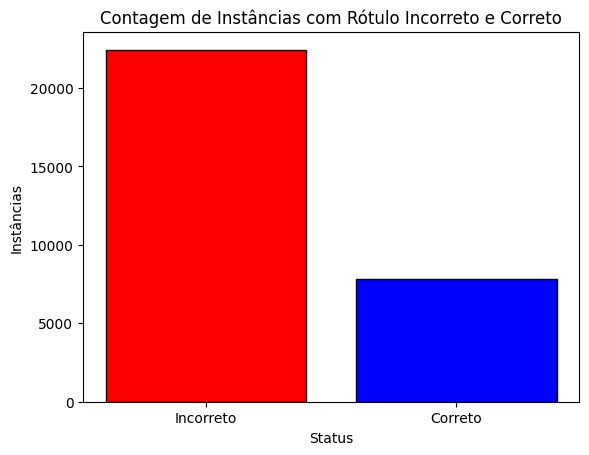

In [ ]:
# Crie um gráfico de barras
plt.bar(counts.index, counts.values, color=['red', 'blue'], edgecolor='k')

# Adicione rótulos e título
plt.xlabel("Status")
plt.ylabel("Instâncias")
plt.title("Contagem de Instâncias com Rótulo Incorreto e Correto")

# Personalize os rótulos no eixo x (opcional)
plt.xticks(counts.index, ['Incorreto', 'Correto'])

# Mostre o gráfico
plt.show()

## Correção de rótulos

Primeiramente, a função has_invalid_characters verifica se a equação possui caracteres inválidos e insere o resultado (Verdadeiro ou Falso) em uma nova coluna.

Após isso, a equação é padronizada e a função resolver_e_comparar resolve initial_equation e currentStep e verifica se seus resultados são iguais (indicando que o passo está correto e que o rótulo deveria constar como correto). Com base nisso, insere uma nova coluna informando se o rótulo do dataset está certo ou errado.

Por fim, a função altera_label, altera os rótulos que estiverem anotados de forma incorreta.

In [ ]:
#Função que verifica se a equação contém caracteres inválidos
def has_invalid_characters(text):

    # Use uma expressão regular para encontrar qualquer caractere que não esteja na lista permitida
    pattern = r'[^*+\-()/=xX\d\s]'  # Qualquer coisa que não seja *, +, -, /, (, ), =, x, dígito ou espaço em branco
    return bool(re.search(pattern, text))

# Aplica a função has_invalid_characters à coluna currentStep e cria uma nova coluna "has_invalid_chars"
log['has_invalid_chars'] = log['currentStep'].apply(has_invalid_characters)

# Exibe as linhas onde foram encontrados caracteres inválidos
invalid_rows = log[log['has_invalid_chars'] == True]
invalid_rows

,initial_equation,currentStep,step_is_correct,has_invalid_chars
13,x+7=23,x=(2)^3-7,0.0,True
21,x+7=23,x=(2)^3-+,0.0,True
638,x+12=27,x=s*(s)^1,0.0,True
659,x+16=28,gg,0.0,True
1095,x-12=19,X=19+'2,0.0,True
...,...,...,...,...
249500,8x=16,x=16;8,0.0,True
250463,-2x+(3x)/(2)=(1)/(3),-x=1/3ger,0.0,True
250830,1x=30,"x=3,0",0.0,True
251008,5x+5-2x=6x-12,"3x-6x=-12-5,",0.0,True


In [ ]:
#Conta o número de instâncias que contém caracteres inválidos
log["has_invalid_chars"].value_counts()

False    29161
True      1118
Name: has_invalid_chars, dtype: int64

Ao todo são 1.118 instâncias que contém caracteres inválidos.

In [ ]:
#Função para padronizar uma equação
def padronizar_equacao(eq_str):
    # Remove espaços em branco e transforma "X" em "x"
    eq_str = eq_str.replace(" ", "").replace("X", "x")

    # Adiciona "*" entre coeficiente e variável (por exemplo, 2x vira 2*x)
    eq_str = re.sub(r'(\d)([a-z])', r'\1*\2', eq_str)

    # Adiciona "*" entre coeficiente e abertura de parênteses (por exemplo, 2(2+4) vira 2*(2+4))
    eq_str = re.sub(r'(\d+)\(', r'\1*(', eq_str)

    # Adiciona "*" entre variável x e abertura de parênteses (por exemplo, x(2+4) vira x*(2+4))
    eq_str = re.sub(r'(x)(\()', r'\1*\2', eq_str)

    return eq_str

In [ ]:
#Função que acha a solução de duas equações e retorna 1 se as soluções são iguais (passo correto) e 0 se são diferentes (passo incorreto)
def resolver_e_comparar(eq1_str, eq2_str):

    # Indicação de variáveis em SymPy
    x = sp.symbols('x')

    try:
        # Padronizar o formato das equações
        eq1_str = padronizar_equacao(eq1_str)
        eq2_str = padronizar_equacao(eq2_str)

        # Retorna 0 (passo incorreto) se a segunda equação (currentStep) possui caracteres inválidos - Sabe-se que são 1.118 instâncias
        if has_invalid_characters(eq2_str):
            return 0

        # Retorna 0 (passo incorreto) se as equações estão vazias
        if not eq1_str or not eq2_str:
            return 0

        # Retorna 0 (passo incorreto) se as equações não possuem sinal de "="
        if "=" not in eq1_str or "=" not in eq2_str:
            return 0

        # Divide ambas as equações pelo sinal de "=" e cria duas listas com as partes (eq1_parts e eq2_parts)
        eq1_parts = eq1_str.split('=')
        eq2_parts = eq2_str.split('=')

        # Retorna 0 (passo incorreto) se as equações contém um número de partes diferente de 2
        if len(eq1_parts) != 2 or len(eq2_parts) != 2:
            return 0

        # Retorna 0 (passo incorreto) se as partes da equação 2 (currentStep) estão vazias
        if eq2_parts[0] == "" or eq2_parts[1] == "":
            return 0

        # Retira os espaços em branco das partes da equação 2 (currentStep)
        eq2_parts[0] = eq2_parts[0].strip()
        eq2_parts[1] = eq2_parts[1].strip()

        # Retorna 0 (passo incorreto) se as partes da equação 2 (currentStep) são iguais a "-0"
        if eq2_parts[0] == "-0" or eq2_parts[1] == "-0":
            return 0

        # Retorna 0 (passo incorreto) se as partes da equação 2 (currentStep) são iguais a "0/"
        if eq2_parts[0].find("0/") != -1:
            return 0
        if eq2_parts[1].find("0/") != -1:
            return 0

        # Retorna 0 (passo incorreto) se as partes da equação 2 (currentStep) são iguais a "(0)/"
        if eq2_parts[0].find("(0)/") != -1:
            return 0
        if eq2_parts[1].find("(0)/") != -1:
            return 0

        # Simplifica e formata as equações para uso no SymPy
        eq1 = sp.Eq(sp.sympify(eq1_parts[0]), sp.sympify(eq1_parts[1]))
        eq2 = sp.Eq(sp.sympify(eq2_parts[0]), sp.sympify(eq2_parts[1]))

        # Tentar resolver as equações apenas se elas estiverem bem formadas
        sol1 = sp.solve(eq1, x)
        sol2 = sp.solve(eq2, x)

        # Compara as soluções das duas equações, retornando 1 para soluções iguais (passo correto) e 0 para soluções diferentes (passo incorreto)
        if sol1 == sol2:
            return 1
        else:
            return 0
    # Lança exceção no caso de erros no SymPy e retorna 0 (passo incorreto)
    except (sp.SympifyError, ValueError, TypeError) as e:
        return 0

In [ ]:
# Aplica a função resolver_e_comparar a cada linha do DataFrame e cria a coluna label_verifica
log['label_verifica'] = log.apply(lambda row: resolver_e_comparar(row['initial_equation'], row['currentStep']), axis=1)

# Mapea os valores de "step_is_correct" e atualiza a coluna "label_verifica" (Label Correto ou Label Incorreto, de acordo com o resultado da função resolver_e_comparar)
log['label_verifica'] = log.apply(lambda row: "Label Correto" if (row['label_verifica'] == 1 and row['step_is_correct'] == 1)
                                           else ("Label Correto" if (row['label_verifica'] == 0 and row['step_is_correct'] == 0)
                                                else "Label Incorreto"), axis=1)

# Visualizar o DataFrame resultante
log

,initial_equation,currentStep,step_is_correct,has_invalid_chars,label_verifica
0,x+4=9,x=9-4,1.0,False,Label Correto
1,x+4=9,x=-5,0.0,False,Label Correto
2,x+4=9,x=+5,1.0,False,Label Correto
3,x+5=8,x=8-3,0.0,False,Label Correto
5,x+5=8,x=8-5,1.0,False,Label Correto
...,...,...,...,...,...
251771,2x-8-5x+25=x+1,-4x=-16,1.0,False,Label Correto
251772,-4x=-16,x=-(16)/(-4),1.0,False,Label Correto
251773,x=-(16)/(-4),x=4,1.0,False,Label Correto
251774,x-8=3x-3,-2x=5,1.0,False,Label Correto


São 28.218 instâncias com rótulo anotado corretamente e 2.061 instâncias com rótulo anotado de forma incorreta

In [ ]:
log.value_counts("label_verifica")

label_verifica
Label Correto      28218
Label Incorreto     2061
dtype: int64

In [ ]:
value_counts_series = log[log['label_verifica'] == 'Label Incorreto']['step_is_correct'].value_counts()

# Acesse as contagens específicas para 1.0 e 100
count_label_incorreto_step_1 = value_counts_series.get(1.0, 0)
count_label_incorreto_step_0 = value_counts_series.get(0.0, 0)

print(f"Quantidade de instâncias com 'Label Incorreto' e step_is_correct igual a 1.0: {count_label_incorreto_step_1}")
print(f"Quantidade de instâncias com 'Label Incorreto' e step_is_correct igual a 0.0: {count_label_incorreto_step_0}")

Quantidade de instâncias com 'Label Incorreto' e step_is_correct igual a 1.0: 276
Quantidade de instâncias com 'Label Incorreto' e step_is_correct igual a 0.0: 1785


Desses 2.061 rótulos anotados incorretamente, 1.785 constam como incorretos e deveriam constar como corretos e 276 constam como corretos e deveriam constar como incorretos.

In [ ]:
#Função que altera os rótulos anotados incorretamente
def altera_label(step_is_correct, label_verifica):

    # Se o rótulo foi anotado incorretamente, inverte o seu valor (se é 1 vira 0 e se é 0 vira 1)
    if label_verifica == "Label Incorreto":
        if step_is_correct == 1.0:
            step_is_correct = 0.0
        elif step_is_correct == 0.0:
            step_is_correct = 1.0

    return step_is_correct

#Atualiza os rótulos com a função altera_label
log['step_is_correct'] = log.apply(lambda row: altera_label(row['step_is_correct'], row['label_verifica']), axis=1)

Após as correções dos rótulos, o código de verificação é novamente chamado para checar se a atualização funcionou corretamente.

In [ ]:
# Aplica a função resolver_e_comparar a cada linha do DataFrame e cria uma coluna label_verifica
log['label_verifica'] = log.apply(lambda row: resolver_e_comparar(row['initial_equation'], row['currentStep']), axis=1)

# Mapea os valores de "step_is_correct" e atualiza a coluna label_verifica
log['label_verifica'] = log.apply(lambda row: "Label Correto" if (row['label_verifica'] == 1 and row['step_is_correct'] == 1)
                                           else ("Label Correto" if (row['label_verifica'] == 0 and row['step_is_correct'] == 0)
                                                else "Label Incorreto"), axis=1)

# Visualizar o DataFrame resultante
print(log)

       initial_equation   currentStep  step_is_correct  has_invalid_chars  \
0                 x+4=9         x=9-4              1.0              False   
1                 x+4=9          x=-5              0.0              False   
2                 x+4=9          x=+5              1.0              False   
3                 x+5=8         x=8-3              0.0              False   
5                 x+5=8         x=8-5              1.0              False   
...                 ...           ...              ...                ...   
251771   2x-8-5x+25=x+1       -4x=-16              1.0              False   
251772          -4x=-16  x=-(16)/(-4)              1.0              False   
251773     x=-(16)/(-4)           x=4              1.0              False   
251774         x-8=3x-3         -2x=5              1.0              False   
251775            -2x=5    x=(5)/(-2)              1.0              False   

       label_verifica  
0       Label Correto  
1       Label Correto  
2  

In [ ]:
#Conta novamente o número de rótulos verificados como informados correta ou incorretamente
log.value_counts("label_verifica")

label_verifica
Label Correto    30279
dtype: int64

A nova verificação não encontrou valores de rótulos incorretos.

In [ ]:
#Conta novamente o número de rótulos corretos e incorretos
counts = log.value_counts("step_is_correct")
counts

step_is_correct
0.0    20919
1.0     9360
dtype: int64

Agora, são 20.919 rótulos incorretos e 9.630 corretos.

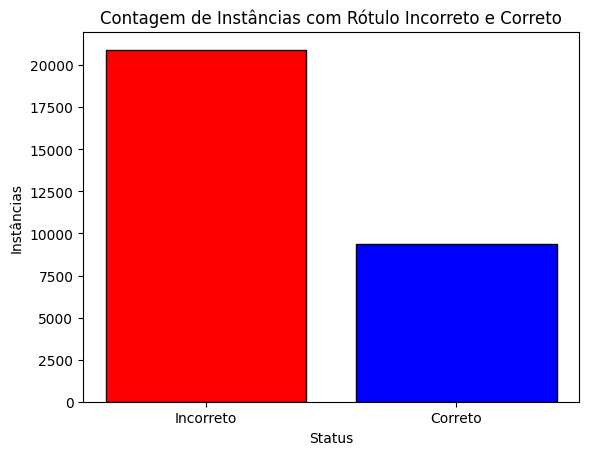

In [ ]:
# Crie um gráfico de barras
plt.bar(counts.index, counts.values, color=['red', 'blue'], edgecolor='k')

# Adicione rótulos e título
plt.xlabel("Status")
plt.ylabel("Instâncias")
plt.title("Contagem de Instâncias com Rótulo Incorreto e Correto")

# Personalize os rótulos no eixo x (opcional)
plt.xticks(counts.index, ['Incorreto', 'Correto'])

# Mostre o gráfico
plt.show()

In [ ]:
#Exclui as colunas label_verifica e has_invalid_chars
log = log[["initial_equation", "currentStep", "step_is_correct"]]

In [ ]:
#Imprime o log atualizado
log

,initial_equation,currentStep,step_is_correct
0,x+4=9,x=9-4,1.0
1,x+4=9,x=-5,0.0
2,x+4=9,x=+5,1.0
3,x+5=8,x=8-3,0.0
5,x+5=8,x=8-5,1.0
...,...,...,...
251771,2x-8-5x+25=x+1,-4x=-16,1.0
251772,-4x=-16,x=-(16)/(-4),1.0
251773,x=-(16)/(-4),x=4,1.0
251774,x-8=3x-3,-2x=5,1.0


## Data Augmentation

*    A primeira função de data augmentation (augment_equation) recebe uma equação da coluna initial equation e o indicador correct (para gerar uma equação correta ou incorreta). Essa função, quando correct é informado como 1, insere operações aleatórias de adição, subtração, multiplicação e divisão dos dois lados da equação. No final, também aleatoriamente, pode inverter os lados da equação. Se correct é 0, a inserção é realizada em apenas um lado da equação, tornando-a incorreta.

*    A segunda função (augment_equation_current) recebe uma equação da coluna initial equation, uma de currentStep e o indicador correct (para gerar uma equação correta ou incorreta). Essa função, quando correct é 1, copia o valor de initial_equation para currentStep e aleatoriamente pode inverter o lado. Se correct é 0, um valor inválido aleatório é inserido em currentStep.

In [ ]:
# Função de data augmentation para alterar initial equation, incluindo instâncias corretas ou incorretas
def augment_equation(equation, correct):

    # Separa os lados da equação e retira os espaços em branco
    left, right = equation.split('=')
    left = left.strip()
    right = right.strip()

    # Seleciona aleatoriamente uma ou duas operações
    choice = random.choice(["add", "multiply", "div", "add&multiply", "add&div"])

    # Gera constantes aleatórias entre -100 e 100 (inclusive)
    constant_to_add = random.randint(-100, 100)
    constant_to_multiply = random.choice([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 0, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10])
    constant_to_div = random.choice([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10])

    # Se correct == 1, adiciona as operações a ambos os lados
    if correct:
      # Adição
      if choice in ["add", "add&multiply", "add&div"]:
        if constant_to_add >= 0:
          left = f"({left}) + {constant_to_add}"
          right = f"({right}) + {constant_to_add}"
        else:
          left = f"({left}) + ({constant_to_add})"
          right = f"({right}) + ({constant_to_add})"

      # Multiplicação
      if choice in ["multiply", "add&multiply"]:
        if constant_to_multiply >= 0:
          left = f"({left}) * {constant_to_multiply}"
          right = f"({right}) * {constant_to_multiply}"
        else:
          left = f"({left}) * ({constant_to_multiply})"
          right = f"({right}) * ({constant_to_multiply})"

      # Divisão
      if choice in ["div", "add&div"]:
        if constant_to_div >= 0:
          left = f"({left}) / {constant_to_div}"
          right = f"({right}) / {constant_to_div}"
        else:
          left = f"({left}) / ({constant_to_div})"
          right = f"({right}) / ({constant_to_div})"

    # Se correct == 0, adiciona as operações apenas no lado esquerdo
    else:

      # Adição
      if choice in ["add", "add&multiply", "add&div"]:
        if constant_to_add >= 0:
          left = f"({left}) + {constant_to_add}"
        else:
          left = f"({left}) + ({constant_to_add})"

      # Multiplicação
      if choice in ["multiply", "add&multiply"]:
        if constant_to_multiply >= 0:
          left = f"({left}) * {constant_to_multiply}"
        else:
          left = f"({left}) * ({constant_to_multiply})"

      # Divisão
      if choice in ["div", "add&div"]:
        if constant_to_div >= 0:
          left = f"({left}) / {constant_to_div}"
        else:
          left = f"({left}) / ({constant_to_div})"

    # Troca os lados da equação aleatoriamente
    if random.choice([True, False]):
        left, right = right, left

    # Retira espaços em branco e retorna equação initial equation modificada
    left = left.replace(" ", "")
    right = right.replace(" ", "")
    return f"{left}={right}"

# Exemplo da equação "2x + 3 = 5" correta e incorreta
equation = "2x + 3 = 5"
augmented_equation1 = augment_equation(equation, 1)
augmented_equation2 = augment_equation(equation, 0)
print("Equação Correta: ", augmented_equation1)
print("Equação Incorreta: ", augmented_equation2)

Equação Correta:  (5)*(-8)=(2x+3)*(-8)
Equação Incorreta:  (2x+3)/(-4)=5


In [ ]:
# Função de data augmentation para alterar currentStep, copiando o valor de initial equation ou incluindo valores inválidos
def augment_equation_current(equation1, equation2, correct):

    # Seleção de valores aleatórios
    choice = random.choice([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
    incorretas = random.choice([",", "&", "y", "a", "^", "[", "]"])
    constant1 = random.randint (-100, 100)
    constant2 = random.randint (-100, 100)

    # Se correct == 1, copia initial equation em currentStep e, aleatoriamente, inverte os lados da equação
    if correct:
      if choice in [1, 2, 3, 4, 5, 6]:
        equation2 = equation1
      else:
        equation2 = equation1
        left, right = equation2.split('=')
        left = left.strip()
        right = right.strip()
        left = left.replace(" ", "")
        right = right.replace(" ", "")
        left, right = right, left
        equation2 = f"{left}={right}"

    # Se correct == 0, altera currentStep para um valor inválido aleatório
    else:
      if choice == 1:
        equation2 = "= x"
      elif choice == 2:
        equation2 = "x"
      elif choice == 3:
        equation2 = f"x={constant1}={constant2}"
      elif choice == 4:
        equation2 = f"x={constant1}{incorretas}{constant2}"
      elif choice == 5:
        equation2 = f"{constant1}"
      elif choice == 6:
        equation2 = "x="
      elif choice == 7:
        equation2 = "-"
      elif choice == 8:
        equation2 = "="
      elif choice == 9:
        equation2 = "+"
      elif choice == 10:
        equation2 = "*"
      elif choice == 11:
        equation2 = "/"

    # Retira espaçoes em branco e retorna currentStep atualizado
    equation2 = equation2.replace(" ", "")
    equation2 = equation2.strip()
    return equation2

# Exemplo de uso da função com "2x + 3 = 5" como initial equation e "x = 7" como currentStep, para geração de equação correta e incorreta
equation1 = "2x + 3 = 5"
equation2 = "x = 7"
augmented_equation_current1 = augment_equation_current(equation1, equation2, 1)
augmented_equation_current2 = augment_equation_current(equation1, equation2, 0)
print("Correta: ", augmented_equation_current1)
print("Incorreta: ", augmented_equation_current2)

Correta:  5=2x+3
Incorreta:  +


In [ ]:
# Variável log_temp recebe rótulos corretos (9.360)
log_temp = log[log["step_is_correct"] == 1.0]

# Variável log_temp_subset recebe um subconjunto dos rótulos corretos (5.049)
log_temp_subset = log_temp.head(7161)

# Variável log_temp_subset2 recebe um subconjunto dos rótulos corretos (2.000)
log_temp_subset2 = log_temp.head(2000)

O código abaixo aplica 5 vezes a função augment_equation com correct == 1, nos rótulos corretos, aumentando de 9.360 instâncias corretas para 56.160.

Após, ele aplica 3 vezes a função augment_equation com correct == 0, nos rótulos corretos e mais uma no subjconjunto de 7.161, aumentando os rótulos incorretos de 20.919 para 56.160.

Por fim, são feitas duas aplicações de augment_equation_current, primeiro com correct == 0 (em 2.000 instâncias) e depois com current == 1 (em 2000 instâncias), aumento os rótulos corretos para 58.160 e os incorretos para 58.160, num total de 116.320 instâncias.

In [ ]:
# Lista de rótulos para as funções
labels = [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]

# Lista para armazenar os DataFrames gerados
new_dataframes = []

# Aplica função augment_equation 5 vezes para geração de equações corretas e 3 para geração de equações incorretas
# Loop para aplicar as funções e criar os DataFrames
for i, lab in enumerate(labels):
    new_rows = log_temp.apply(lambda row: pd.Series({'initial_equation': augment_equation(row['initial_equation'], int(labels[i])),
                                                     'currentStep': row['currentStep'],
                                                     'step_is_correct': labels[i]}), axis=1)
    # Anexar as novas linhas ao DataFrame original
    log = log.append(new_rows, ignore_index=True)

# Aplica função augment_equation para geração de equações incorretas
new_rows = log_temp_subset.apply(lambda row: pd.Series({'initial_equation': augment_equation(row['initial_equation'], 0),
                                                     'currentStep': row['currentStep'],
                                                     'step_is_correct': 0.0}), axis=1)
# Anexar as novas linhas ao DataFrame original
log = log.append(new_rows, ignore_index=True)

# Aplica função augment_equation_current para geração de equações incorretas
new_rows = log_temp_subset2.apply(lambda row: pd.Series({'initial_equation': augment_equation_current(row['initial_equation'], row['currentStep'], 0),
                                                     'currentStep': row['currentStep'],
                                                     'step_is_correct': 0.0}), axis=1)
# Anexar as novas linhas ao DataFrame original
log = log.append(new_rows, ignore_index=True)

# Aplica função augment_equation_current para geração de equações corretas
new_rows = log_temp_subset2.apply(lambda row: pd.Series({'initial_equation': augment_equation_current(row['initial_equation'], row['currentStep'], 1),
                                                     'currentStep': row['currentStep'],
                                                     'step_is_correct': 1.0}), axis=1)
# Anexar as novas linhas ao DataFrame original
log = log.append(new_rows, ignore_index=True)

# Imprime o log atualizado
log

<ipython-input-203-21346393a1d6>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(new_rows, ignore_index=True)
<ipython-input-203-21346393a1d6>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(new_rows, ignore_index=True)
<ipython-input-203-21346393a1d6>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(new_rows, ignore_index=True)
<ipython-input-203-21346393a1d6>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(new_rows, ignore_index=True)
<ipython-input-203-21346393a1d6>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

,initial_equation,currentStep,step_is_correct
0,x+4=9,x=9-4,1.0
1,x+4=9,x=-5,0.0
2,x+4=9,x=+5,1.0
3,x+5=8,x=8-3,0.0
4,x+5=8,x=8-5,1.0
...,...,...,...
116315,(2x)/(6)=(4x+1)/(10),x=(3)/(-2),1.0
116316,80-(-80+2x)=-(5x+4)-27,-2x+5x=-4-27-160,1.0
116317,(8x-4)-(-5+6x)=0,-6x+8x=-5+4,1.0
116318,17x-2+4=10+5x,17x-5x= 10+2-4,1.0


In [ ]:
# Contar o número de ocorrências de step_is_correct igual a 1 e 0
count_correct = log['step_is_correct'].value_counts()[1.0]
count_incorrect = log['step_is_correct'].value_counts()[0.0]

print("Número de linhas com passos corretos:", count_correct)
print("Número de linhas com passos incorretos:", count_incorrect)

Número de linhas com passos corretos: 58160
Número de linhas com passos incorretos: 58160


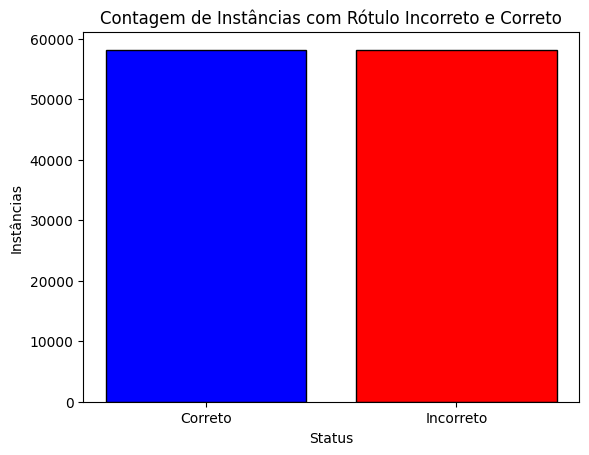

In [ ]:
# Variável counts recebe os valores de rótulos corretos e incorretos
counts = log["step_is_correct"].value_counts()

# Crie um gráfico de barras
plt.bar(counts.index, counts.values, color=['red', 'blue'], edgecolor='k')

# Adicione rótulos e título
plt.xlabel("Status")
plt.ylabel("Instâncias")
plt.title("Contagem de Instâncias com Rótulo Incorreto e Correto")

# Personalize os rótulos no eixo x (opcional)
plt.xticks(counts.index, ['Incorreto', 'Correto'])

# Mostre o gráfico
plt.show()

In [ ]:
# Exclui os valores duplicados novamente, desde que constem como iguais em ambas as colunas: initial equation e currentStep
log = log.drop_duplicates(subset=['initial_equation', 'currentStep'])
log.head(), log.shape

(  initial_equation currentStep  step_is_correct
 0            x+4=9       x=9-4              1.0
 1            x+4=9        x=-5              0.0
 2            x+4=9        x=+5              1.0
 3            x+5=8       x=8-3              0.0
 4            x+5=8       x=8-5              1.0,
 (114884, 3))

In [ ]:
# Contar o número de ocorrências de step_is_correct igual a 1 e 0
counts = counts = log["step_is_correct"].value_counts()
counts

0.0    58045
1.0    56839
Name: step_is_correct, dtype: int64

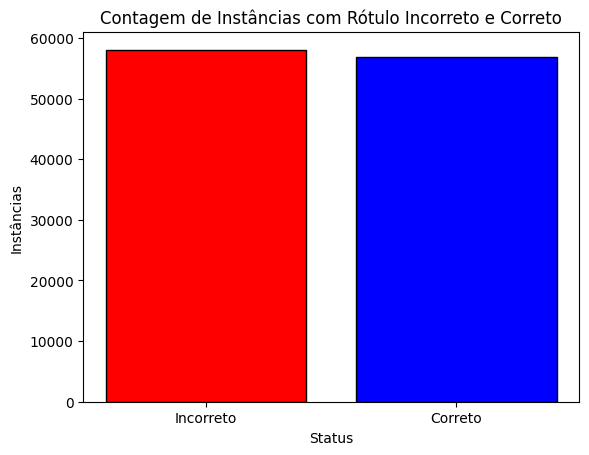

In [ ]:
# Crie um gráfico de barras
plt.bar(counts.index, counts.values, color=['red', 'blue'], edgecolor='k')

# Adicione rótulos e título
plt.xlabel("Status")
plt.ylabel("Instâncias")
plt.title("Contagem de Instâncias com Rótulo Incorreto e Correto")

# Personalize os rótulos no eixo x (opcional)
plt.xticks(counts.index, ['Incorreto', 'Correto'])

# Mostre o gráfico
plt.show()

Após a nova exclusão de dados duplicados, restaram 58.045 instâncias com rótulos incorretos e 56.839 com rótulos corretos, totalizando 114.884 instâncias.

In [ ]:
#Imprime log atualizado
log

,initial_equation,currentStep,step_is_correct
0,x+4=9,x=9-4,1.0
1,x+4=9,x=-5,0.0
2,x+4=9,x=+5,1.0
3,x+5=8,x=8-3,0.0
4,x+5=8,x=8-5,1.0
...,...,...,...
116304,(x)/(20)=(80)/(50),-5x=-160,1.0
116307,(4x+1)/(10)=(2x)/(6),20x=6*(4x+1),1.0
116309,(4x+1)/(10)=(2x)/(6),20x=24x+6,1.0
116310,(4x+1)/(10)=(2x)/(6),-2x=3,1.0


## Criando o dataframe passos

As equações initial equation e currentStep são mescladas em uma úninca entrada chamada de input_sequence, unidas pelo separador [SEP], enquanto step_is_correct continua como rótulo, desta vez com valor inteiro.

In [ ]:
# Inicialize o DataFrame 'passos'
passos = pd.DataFrame()

# Em seguida, criamos a nova coluna combinando as duas colunas de entrada.
passos['input_sequence'] = log['initial_equation'] + ' [SEP] ' + log['currentStep']
passos['step_is_correct'] = log['step_is_correct'].astype(int)

In [ ]:
passos.head()

,input_sequence,step_is_correct
0,x+4=9 [SEP] x=9-4,1
1,x+4=9 [SEP] x=-5,0
2,x+4=9 [SEP] x=+5,1
3,x+5=8 [SEP] x=8-3,0
4,x+5=8 [SEP] x=8-5,1


In [ ]:
passos

,input_sequence,step_is_correct
0,x+4=9 [SEP] x=9-4,1
1,x+4=9 [SEP] x=-5,0
2,x+4=9 [SEP] x=+5,1
3,x+5=8 [SEP] x=8-3,0
4,x+5=8 [SEP] x=8-5,1
...,...,...
116304,(x)/(20)=(80)/(50) [SEP] -5x=-160,1
116307,(4x+1)/(10)=(2x)/(6) [SEP] 20x=6*(4x+1),1
116309,(4x+1)/(10)=(2x)/(6) [SEP] 20x=24x+6,1
116310,(4x+1)/(10)=(2x)/(6) [SEP] -2x=3,1


Embaralhar o conjunto de dados.

In [ ]:
# Cria variável para embaralhar o conjunto de dados
passos_embaralhados = shuffle(passos)

In [ ]:
# Embaralha os dados de entrada e os rótulos
X_series = passos_embaralhados['input_sequence']
y_series = passos_embaralhados['step_is_correct']
X = X_series.tolist()
y = y_series.tolist()

## Tokenização e Encoding

Baseado em https://colab.research.google.com/github/peterbayerle/huggingface_notebook/blob/main/distilbert_tf.ipynb#scrollTo=fKTJqUF5R-o4





Uma vez que estamos usando o modelo DistilBERT, o primeiro passo de pré-processamento é converter cada string de passo algébrico em nosso conjunto de dados em uma tupla contendo os IDs de entrada e as máscaras de atenção do passo. Isso é realizado usando o `DistilBertTokenizerFast` da biblioteca Transformers.

Aqui, `MAX_LEN` especifica o comprimento de cada passo tokenizado. Se um passo tokenizado for menor que `MAX_LEN`, ele será preenchido com zeros. Se um passo tokenizado for maior que `MAX_LEN`, ele será truncado (é por isso que temos `truncation=True` e `padding=True`).

In [ ]:
# Comprimento de cada passo tokenizado
MAX_LEN = 20

In [ ]:
# Inicializar o tokenizador e o modelo
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Tokenização dos conjuntos de treinamento e teste
encodings = tokenizer(X, truncation=True, padding=True)

In [ ]:
#Transformando os dados em um dataset tensorflow para otimizar o processamento da rede neural
tfdataset = tf.data.Dataset.from_tensor_slices((dict(encodings),y))

## Divisão de conjuntos

Aqui os dados são divididos em três conjuntos: conjunto de treinamento, com 70% das instâncias, conjunto de validação, com 20% das instâncias e conjunto de testes, com 10% das instâncias. Além disso, o tamanho de lote é definido com 32.

In [ ]:
TEST_SPLIT = 0.1 # Conjunto de teste com 10% dos passos
VAL_SPLIT = 0.2 # Conjunto de validação com 20% dos passos
BATCH_SIZE = 32 # Tamanho do lote

# Define o tamanho dos três conjuntos de dados
train_size = int(len(X) * (1 - (TEST_SPLIT + VAL_SPLIT)))
val_size = int(len(X) * VAL_SPLIT)

tfdataset_train = tfdataset.take(train_size)
remainder = tfdataset.skip(train_size)

tfdataset_val = remainder.take(val_size)
tfdataset_test = remainder.skip(val_size)

# Exibir os tamanhos dos conjuntos de dados resultantes
print("Tamanho do conjunto de treinamento:", len(tfdataset_train))
print("Tamanho do conjunto de validação:", len(tfdataset_val))
print("Tamanho do conjunto de teste:", len(tfdataset_test))

tfdataset_train = tfdataset_train.batch(BATCH_SIZE)
tfdataset_val = tfdataset_val.batch(BATCH_SIZE)
tfdataset_test = tfdataset_test.batch(BATCH_SIZE)

Tamanho do conjunto de treinamento: 80418
Tamanho do conjunto de validação: 22976
Tamanho do conjunto de teste: 11490


# Treinamento e Validação

Aqui o modelo é treinado e validado. O melhor modelo é armazenado na variável 'melhor_modelo'.

O treinamento é realizado com 25 épocas, otimizador Adam com learning rate de 3e*5 e função de loss Sparse Categorical Crossentropy. O modelo utiliza o transformer DistilBertforSequence Classsification.

In [ ]:
# Hiperparâmetros configuráveis
N_EPOCHS = 25
MODEL_NAME = 'distilbert-base-uncased'
LEARNING_RATE = 3e-5
CHECKPOINT_FILE = 'melhor_modelo'

In [ ]:
# Cria um callback ModelCheckpoint para salvar o melhor modelo com base na perda de validação
checkpoint = ModelCheckpoint(CHECKPOINT_FILE, monitor='val_loss', save_best_only=True, save_format='tf')

# Carrega o modelo pré-treinado DistilBERT
model = TFDistilBertForSequenceClassification.from_pretrained(MODEL_NAME)

# Define o otimizador, função de perda e métricas
optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
loss = losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Treina o modelo usando model.fit()
history = model.fit(tfdataset_train, epochs=N_EPOCHS, batch_size=BATCH_SIZE,
                    validation_data=tfdataset_val, callbacks=[checkpoint])

# Imprime as métricas de treinamento e validação
print("Training loss:", history.history['loss'])
print("Training accuracy:", history.history['accuracy'])
print("Validation loss:", history.history['val_loss'])
print("Validation accuracy:", history.history['val_accuracy'])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/25
2514/2514 [==============================] - ETA: 0s - loss: 0.1853 - accuracy: 0.9059

2514/2514 [==============================] - 806s 310ms/step - loss: 0.1853 - accuracy: 0.9059 - val_loss: 0.1563 - val_accuracy: 0.9169
Epoch 2/25
2513/2514 [============================>.] - ETA: 0s - loss: 0.1494 - accuracy: 0.9207

2514/2514 [==============================] - 782s 311ms/step - loss: 0.1494 - accuracy: 0.9207 - val_loss: 0.1398 - val_accuracy: 0.9253
Epoch 3/25
2513/2514 [============================>.] - ETA: 0s - loss: 0.1361 - accuracy: 0.9287

2514/2514 [==============================] - 782s 311ms/step - loss: 0.1361 - accuracy: 0.9287 - val_loss: 0.1362 - val_accuracy: 0.9307
Epoch 4/25
2513/2514 [============================>.] - ETA: 0s - loss: 0.1260 - accuracy: 0.9351

2514/2514 [==============================] - 781s 311ms/step - loss: 0.1260 - accuracy: 0.9351 - val_loss: 0.1358 - val_accuracy: 0.9332
Epoch 5/25
2513/2514 [============================>.] - ETA: 0s - loss: 0.1177 - accuracy: 0.9406

2514/2514 [==============================] - 782s 311ms/step - loss: 0.1177 - accuracy: 0.9406 - val_loss: 0.1307 - val_accuracy: 0.9348
Epoch 6/25
2514/2514 [==============================] - 765s 304ms/step - loss: 0.1114 - accuracy: 0.9445 - val_loss: 0.1333 - val_accuracy: 0.9363
Epoch 7/25
2513/2514 [============================>.] - ETA: 0s - loss: 0.1030 - accuracy: 0.9495

2514/2514 [==============================] - 782s 311ms/step - loss: 0.1030 - accuracy: 0.9495 - val_loss: 0.1216 - val_accuracy: 0.9402
Epoch 8/25
2514/2514 [==============================] - 765s 304ms/step - loss: 0.0950 - accuracy: 0.9541 - val_loss: 0.1254 - val_accuracy: 0.9404
Epoch 9/25
2514/2514 [==============================] - 766s 305ms/step - loss: 0.0892 - accuracy: 0.9576 - val_loss: 0.1314 - val_accuracy: 0.9410
Epoch 10/25
2514/2514 [==============================] - 765s 304ms/step - loss: 0.0826 - accuracy: 0.9619 - val_loss: 0.1393 - val_accuracy: 0.9438
Epoch 11/25
2514/2514 [==============================] - 765s 304ms/step - loss: 0.0766 - accuracy: 0.9653 - val_loss: 0.1425 - val_accuracy: 0.9449
Epoch 12/25
2514/2514 [==============================] - 765s 304ms/step - loss: 0.0704 - accuracy: 0.9689 - val_loss: 0.1221 - val_accuracy: 0.9460
Epoch 13/25
2513/2514 [============================>.] - ETA: 0s - loss: 0.0644 - accuracy: 0.9714

2514/2514 [==============================] - 781s 311ms/step - loss: 0.0644 - accuracy: 0.9714 - val_loss: 0.1193 - val_accuracy: 0.9479
Epoch 14/25
2514/2514 [==============================] - 766s 305ms/step - loss: 0.0592 - accuracy: 0.9743 - val_loss: 0.1454 - val_accuracy: 0.9487
Epoch 15/25
2514/2514 [==============================] - 765s 304ms/step - loss: 0.0548 - accuracy: 0.9766 - val_loss: 0.1290 - val_accuracy: 0.9492
Epoch 16/25
2514/2514 [==============================] - 765s 304ms/step - loss: 0.0501 - accuracy: 0.9791 - val_loss: 0.1544 - val_accuracy: 0.9500
Epoch 17/25
2514/2514 [==============================] - 765s 304ms/step - loss: 0.0478 - accuracy: 0.9800 - val_loss: 0.1556 - val_accuracy: 0.9503
Epoch 18/25
2514/2514 [==============================] - 765s 304ms/step - loss: 0.0444 - accuracy: 0.9820 - val_loss: 0.1496 - val_accuracy: 0.9512
Epoch 19/25
2514/2514 [==============================] - 765s 304ms/step - loss: 0.0421 - accuracy: 0.9830 - val_loss:

# Teste

O melhor modelo, de acordo com o menor valor de loss no conjunto de validação, é testado no conjunto de testes, que possui 11.490 instâncias.

In [ ]:
# Avaliação do modelo no conjunto de testes
benchmarks = model.evaluate(tfdataset_test, return_dict=True, batch_size=BATCH_SIZE)
print(benchmarks)

360/360 [==============================] - 35s 97ms/step - loss: 0.1655 - accuracy: 0.9553
{'loss': 0.16549012064933777, 'accuracy': 0.955265462398529}


## Gráficos da evolução da acurácia e da perda nos conjuntos de treinamento e validação.

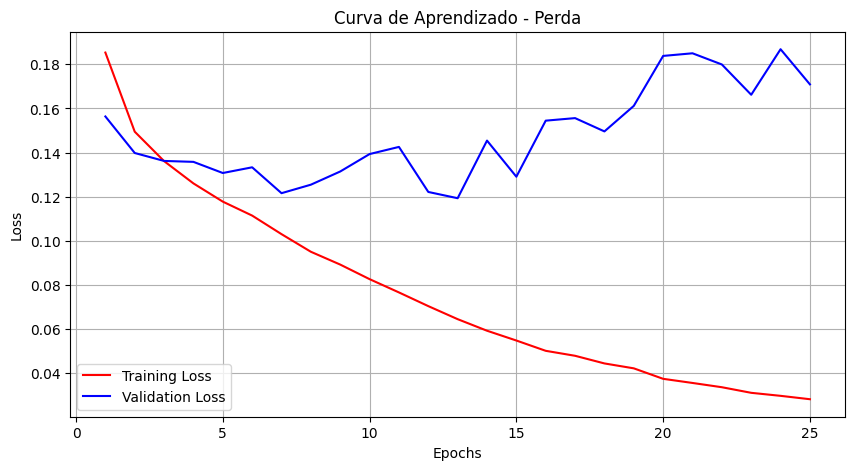

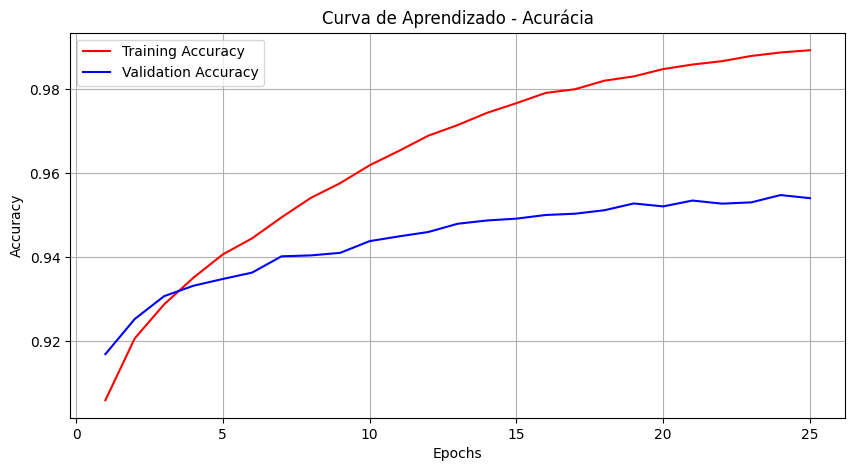

In [ ]:
# Plotar a curva de aprendizado da perda
plt.figure(figsize=(10, 5))
plt.plot(range(1, N_EPOCHS+1), history.history['loss'], 'r', label='Training Loss')
plt.plot(range(1, N_EPOCHS+1), history.history['val_loss'], 'b', label='Validation Loss')
plt.title('Curva de Aprendizado - Perda')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plotar a curva de aprendizado da acurácia
plt.figure(figsize=(10, 5))
plt.plot(range(1, N_EPOCHS+1), history.history['accuracy'], 'r', label='Training Accuracy')
plt.plot(range(1, N_EPOCHS+1), history.history['val_accuracy'], 'b', label='Validation Accuracy')
plt.title('Curva de Aprendizado - Acurácia')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

Código para inserção e teste de uma initial equation e um currentStep

In [ ]:
# Lista com a initial equation e currentStep
temp_steps = ["( x - 1 ) / ( 5 ) - ( 5 - 2x ) / ( 3 ) = ( x ) / ( 1 )", "3x + 10x - 15x = + 25 + 3"]

# Retira os espaços em brando
temp_steps[0] = temp_steps[0].replace(" ", "")
temp_steps[1] = temp_steps[1].replace(" ", "")

# Combina as equações em uma única entrada com [SEP]
steps = temp_steps[0] + ' [SEP] ' + temp_steps[1]

# Tokeniza e codifica as entradas
inputs = tokenizer(steps, truncation=True, padding=True, return_tensors="tf")

# Realiza a predição com os tensores tokenizados
input_ids = inputs['input_ids']
input_ids_tensor = tf.convert_to_tensor(input_ids)

# Obtém as probabilidades das classes
predictions = model(input_ids_tensor)
probabilities = tf.nn.softmax(predictions.logits, axis=1)

# Obtém a probabilidade da classe correta (classe 1)
probability_correct = probabilities[0][1].numpy()

# Determina se a previsão está correta ou incorreta com base em um limite (por exemplo, 0,5)
is_correct = probability_correct > 0.5

# Formata a probabilidade como um valor percentual
probability_percent = probability_correct * 100

# Separa as etapas usando [SEP]
equation_initial, step_by_student = steps.split(" [SEP] ")

# Imprime as informações
print(f"Equação Inicial: {equation_initial}")
print(f"Passo do Aluno: {step_by_student}")
print(f"Probabilidade de estar Correto: {probability_percent:.2f}%")
print(f"Resultado: {'Correto' if is_correct else 'Incorreto'}")

Equação Inicial: (x-1)/(5)-(5-2x)/(3)=(x)/(1)
Passo do Aluno: 3x+10x-15x=+25+3
Probabilidade de estar Correto: 99.01%
Resultado: Correto


## Tabela com a lista de equações de teste, rótulos e probabilidades

A tabela abaixo lista todas as equações iniciais e passos atuais do conjunto de testes. Para cada uma, a tabela mostra a probabilidade com que o modelo chegou a uma predição, o rótulo predito, o rótulo real e o resultado (se o modelo acertou ou errou a predição).

In [ ]:
# Listas para armazenar as previsões, probabilidades e inputs
predictions = []
probabilities = []
inputs_list = []  # Lista para armazenar os IDs de entrada
labels_list = []

# Função para decodificar mantendo apenas o [SEP]
def decode_with_sep(input_ids):
    input_text = tokenizer.decode(input_ids)
    # Remova todos os tokens especiais, exceto [SEP]
    input_text = input_text.replace("[CLS]", "").replace("[PAD]", "").replace("[UNK]", "")
    return input_text.strip()

# Loop através do conjunto de testes
for batch in tfdataset_test:
    # Obtém as entradas e os rótulos do lote
    inputs, labels = batch

    # Realiza a previsão com os tensores de entrada
    predictions_batch = model(inputs)

    # Obtém as probabilidades das classes
    probabilities_batch = tf.nn.softmax(predictions_batch.logits, axis=1)

    # Obtém as probabilidades da classe correta (classe 1)
    probabilities_correct = probabilities_batch[:, 1].numpy()

    # Determina se as previsões estão corretas ou incorretas com base em um limite (por exemplo, 0,5)
    is_correct_batch = probabilities_correct > 0.5

    # Armazena as previsões e probabilidades deste lote
    predictions.extend(is_correct_batch)
    probabilities.extend(probabilities_correct)

    # Adiciona apenas os IDs de entrada à lista
    inputs_list.extend(inputs["input_ids"].numpy())  # Adicione ".numpy()" para converter o tensor para uma lista

    # Adiciona os rótulos à lista de rótulos
    labels_list.extend(labels.numpy())  # Adicione ".numpy()" para converter o tensor para uma lista

# Decodifica os IDs de entrada em texto mantendo apenas o [SEP]
input_texts = [decode_with_sep(ids) for ids in inputs_list]

input_texts1 = []
input_texts2 = []

for text in input_texts:
    try:
        # Divida o texto pelo [SEP] no meio e retira os espaços
        it1, it2 = text.split("[SEP]", 1)
        it2 = it2.replace("[SEP]", "")
        it1 = it1.rstrip()
        it2 = it2.rstrip()
        input_texts1.append(it1)
        input_texts2.append(it2)
    except ValueError:
        # Se houver um erro ao dividir, imprime o texto problemático e continue
        print(f"Erro ao dividir o texto: {text}")

# Cria uma lista de resultados com base na comparação entre Previsão e Rótulo
resultados = ["Certo" if p == r else "Errado" for p, r in zip(predictions, labels_list)]

# Crie um DataFrame com as previsões, probabilidades e entradas originais
data = {
    "Equação Inicial": input_texts1,  # Use os textos decodificados
    "Passo Atual": input_texts2,  # Use os textos decodificados
    "Probabilidade (%)": [p * 100 for p in probabilities],
    "Rótulo Predito": [1 if p else 0 for p in predictions],
    "Rótulo Verdadeiro": labels_list,  # Adicione a lista de rótulos
    "Resultado": resultados  # Adicione a lista de resultados
}
df = pd.DataFrame(data)

In [ ]:
#Imprime o dataframe/tabela
df

,Equação Inicial,Passo Atual,Probabilidade (%),Rótulo Predito,Rótulo Verdadeiro,Resultado
0,( x ) / ( 2 ) + ( x ) / ( 3 ) = ( x + 6 ) / ( 3 ),3x + 2x = 2x + 12x,0.569329,0,0,Certo
1,12x = 6,x = ( 0 ) / ( 12 ),0.000567,0,0,Certo
2,( ( 12x - 3x - 3 ) + ( - 27 ) ) / ( - 7 ) = 12...,x = ( 15 ) / ( 7 ),0.000243,0,0,Certo
3,( 1 ) / ( 2 ) = ( 2x - ( 7 ) / ( 5 ) - ( x ) /...,20x - 14 - 1x = 5,0.000296,0,0,Certo
4,x = - ( 42 ) / ( 30 ),x = - 12 / 25,11.149269,0,0,Certo
...,...,...,...,...,...,...
11485,( x + 2 ) + ( - 39 ) = 20,x = 20 - 2,0.000251,0,0,Certo
11486,( ( ( x ) / ( 500 ) ) + ( - 82 ) ) / 4 = ( ( (...,5x - x = - 10,99.999452,1,1,Certo
11487,( ( 36 ) + ( - 28 ) ) * 9 = ( ( 3x - 3 + 2x - ...,3x + 2x = 36 + 6 + 3,99.999619,1,1,Certo
11488,( ( 10 - ( - x - 1 ) ) + 52 ) * 5 = 0,x = 0 - 1 - 10,0.000271,0,0,Certo


import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df, *['Probabilidade (%)'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df, *['Rótulo Predito'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df, *['Rótulo Verdadeiro'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df, *['Probabilidade (%)'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df, *['Rótulo Predito'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df, *['Rótulo Verdadeiro'], **{})
chart

import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(df, *['Resultado'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plots(df, colname_pairs, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * 6 * figscale, 6 * figscale))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha, ax=ax)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(df, *[[['Probabilidade (%)', 'Rótulo Predito'], ['Rótulo Predito', 'Rótulo Verdadeiro']]], **{})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(df, *['Probabilidade (%)', 'Resultado'], **{'inner': 'box'})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(df, *['Rótulo Predito', 'Resultado'], **{'inner': 'box'})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(df, *['Rótulo Verdadeiro', 'Resultado'], **{'inner': 'box'})
chart

Verifica o número de instâncias classificadas corretamente pelo modelo.

In [ ]:
#Verifica o número de instâncias classificadas corretamente pelo modelo
df["Resultado"].value_counts()

Certo     10976
Errado      514
Name: Resultado, dtype: int64

Calcula o percentual de acerto do modelo, com base na tabela criada.

In [ ]:
# Contagem dos valores "Certo" e "Errado" na coluna "Resultado"
contagem_resultados = df["Resultado"].value_counts()

# Calcula o percentual de acerto
percentual_acerto = (contagem_resultados["Certo"] / len(df)) * 100

# Imprime o percentual de acerto
print(f"Percentual de acerto: {percentual_acerto:.2f}%")

Percentual de acerto: 95.53%


## Matriz de confusão

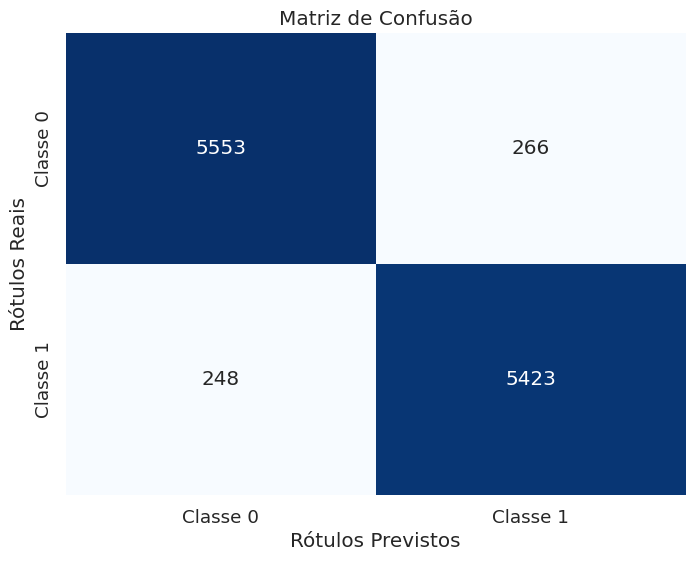

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calcular a matriz de confusão
cm = confusion_matrix(labels_list, [1 if p else 0 for p in predictions])

# Definir rótulos das classes (substitua pelos seus rótulos)
class_names = ['Classe 0', 'Classe 1']

# Criar um heatmap da matriz de confusão
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Rótulos Previstos')
plt.ylabel('Rótulos Reais')
plt.title('Matriz de Confusão')
plt.show()